In [1]:
import os
from collections import OrderedDict

import PIL
import importlib
import numpy as np
import pickle
import torch
from IPython.display import clear_output
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, auc
from skimage.io import imread
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from tqdm import tqdm

from settings.paths import LFW_PAIRS_6000, \
                           LFW_FUNNELED_DIR, \
                           LIGHT_CNN_9_WEIGHT, \
                           SRGAN_MSE_LOSS_WEIGHTS_DIR, \
                           SRGAN_VGG_LOSS_3_1_GENERATOR_WEIGHTS_DIR, \
                           SRGAN_VGG_LOSS_3_1_NO_ADVERSARIAL_WEIGHTS_DIR, \
                           SRGAN_LIGHT_CNN_9_LOSS_MFM4_GENERATOR_WEIGHTS_DIR, \
                           SRGAN_LIGHT_CNN_9_LOSS_MFM4_NO_ADVERSARIAL_WEIGHTS_DIR, \
                           SRGAN_LIGHT_CNN_9_LOSS_FC_NO_ADVERSARIAL_WEIGHTS_DIR, \
                           SRGAN_LIGHT_CNN_9_LOSS_MFM4_NO_ADVERSARIAL_NO_IMAGE_WEIGHTS_DIR, \
                           ROC_AUC_DIR
                
from src.light_cnn import LightCNN_9Layers
from src.srgan import Generator

plt.style.use('ggplot')

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = '7'

In [3]:
COLORS_LIST = [
     'b', 'm', 'g',
     'c', 'y', 'k',
     'gray', 'sienna',
     'gold', 'deepskyblue',
     'pink',
 ]

In [4]:
def init_model(name='LightCNN_9', cuda=True):
    if name is 'LightCNN_9':
        model_class = LightCNN_9Layers
        num_classes=79077
    else:
        raise ValueError('No such model {}'.format(name))
        
    model = model_class(num_classes=num_classes)
    model.eval()
    
    if cuda:
        model = torch.nn.DataParallel(model).cuda()
    
    return model

In [5]:
def load_weights(model, weight_path):
    checkpoint = torch.load(weight_path)
    model.load_state_dict(checkpoint['state_dict'])
    return model

In [6]:
model = init_model('LightCNN_9', cuda=True)
model = load_weights(model, LIGHT_CNN_9_WEIGHT)

In [7]:
class LFWFunneled6000Pairs(Dataset):
    def __init__(self, lfw_funneled_dir, pairs_file, additional_transform=None):
        self._lfw_funneled_dir = lfw_funneled_dir
        self._pairs = open(pairs_file).read().split('\n')
        
        transforms_list = [
            transforms.ToPILImage(),
            transforms.CenterCrop(128),
        ]
        if additional_transform is not None:
            transforms_list.extend(additional_transform)
        transforms_list.append(transforms.ToTensor())
        
        self._transforms = transforms.Compose(transforms_list)
        
    def _make_filepath(self, name, number):
        image_name ='{}_{:04d}.jpg'.format(name, int(number))
        return os.path.join(self._lfw_funneled_dir, name, image_name)
        
    def __getitem__(self, index):
        pair = self._pairs[index + 1].split('\t')
        if len(pair) == 3:
            label = 1
            name, number_1, number_2 = pair

            image_path_1 = self._make_filepath(name, number_1)
            image_path_2 = self._make_filepath(name, number_2)
        elif len(pair) == 4:
            label = 0
            name_1, number_1, name_2, number_2 = pair

            image_path_1 = self._make_filepath(name_1, number_1)
            image_path_2 = self._make_filepath(name_2, number_2)

        return self._transforms(imread(image_path_1)), \
               self._transforms(imread(image_path_2)), \
               label

    def __len__(self):
        return 6000


In [8]:
def calculate_roc(lwf_loader, embeddings_model, upscale_model=None, desc='', checkpoint_file=None):
    post_transform = transforms.Compose(
        [
            transforms.ToPILImage(),
            transforms.Grayscale(),
            transforms.ToTensor(),
        ]
    )
    
    labels = []
    thresholds = []
    
    if upscale_model is not None and checkpoint_file is not None:
        upscale_model.load_state_dict(torch.load(checkpoint_file))
    
    for image_batch_1, image_batch_2, current_labels in tqdm(lwf_loader, desc=desc):
        if upscale_model is not None:
            image_variable_1 = upscale_model(Variable(image_batch_1, volatile=True).cuda())
            image_variable_2 = upscale_model(Variable(image_batch_2, volatile=True).cuda())
            image_batch_1 = image_variable_1.data.cpu()
            image_batch_2 = image_variable_2.data.cpu()
        
        image_grayscale_1 = []
        image_grayscale_2 = []
        for image_num in range(image_batch_1.size()[0]):
            image_grayscale_1.append(post_transform(image_batch_1[image_num]))
            image_grayscale_2.append(post_transform(image_batch_2[image_num]))
            
        image_grayscale_1 = torch.stack(image_grayscale_1)
        image_grayscale_2 = torch.stack(image_grayscale_2)
        
        _, features_1 = embeddings_model(Variable(image_grayscale_1, volatile=True).cuda())
        _, features_2 = embeddings_model(Variable(image_grayscale_2, volatile=True).cuda())
        
        current_thresholds = -torch.mean((features_1 - features_2) ** 2, dim=-1)
        
        thresholds.extend(current_thresholds.data.cpu().numpy())
        labels.extend(current_labels)
        
    fpr, tpr, thresholds = roc_curve(labels, thresholds)
    
    return fpr, tpr

In [9]:
def calculate_roc_auc(*args, **kwargs):
    return auc(*calculate_roc(*args, **kwargs))

In [10]:
def draw_roc(fpr, tpr, name, main_color='red'):
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(10, 6))
    lw = 2
    plt.plot(fpr, tpr, color=main_color,
             lw=lw, label='ROC curve (area = %0.6f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(name)
    plt.legend(loc="lower right")
    plt.show()
    
    return roc_auc

In [11]:
def draw_rocs(roc_curves, colors=COLORS_LIST, crop=False):
    plt.figure(figsize=(15, 9))
    lw = 1.5
    
    for (name, (fpr, tpr)), color in zip(roc_curves.items(), colors):
        roc_auc = auc(fpr, tpr)
        linestyle = '-'
        plt.plot(fpr, tpr, color=color, alpha=0.6,
                 lw=lw, label='{} (area = {:0.6f})'.format(name, roc_auc),
                 linestyle=linestyle)
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        
    if crop is True:
        plt.xlim([0.0, 0.3])
        plt.ylim([0.7, 1.0])
    else:
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curves')
    plt.legend(loc="lower right")
    
    plt.show()

In [12]:
def show_pil_batch(batch, upscale_model=None, checkpoint_file=None):
    if upscale_model is not None and checkpoint_file is not None:
        upscale_model.load_state_dict(torch.load(checkpoint_file))
        result = upscale_model(Variable(next(iter(batch))[0], volatile=True).cuda()).data.cpu()
    else:
        result = next(iter(batch))[0]
    
    images = [transforms.ToPILImage()(torch.clamp(image, 0, 1)) for image in result]

    fig = plt.figure(figsize=(20, 7))
    columns = 5
    rows = 1
    for num, image in zip(range(1, columns * rows + 1), images[:5]):
        fig.add_subplot(rows, columns, num)
        plt.imshow(image)
        plt.grid(True)
        plt.xticks([])
        plt.yticks([])
    plt.show()
    
    return images

In [13]:
roc_auc_scores = OrderedDict()
roc_curves = OrderedDict()

## HR

In [14]:
approach_name = 'HR'

In [15]:
lwf_dataset_hr = LFWFunneled6000Pairs(LFW_FUNNELED_DIR, LFW_PAIRS_6000)
lwf_loader_hr = DataLoader(
    dataset=lwf_dataset_hr,
    batch_size=16,
    num_workers=4,
    shuffle=False
)

In [16]:
fpr, tpr = calculate_roc(lwf_loader_hr, model)

100%|██████████| 375/375 [00:31<00:00, 14.80it/s]


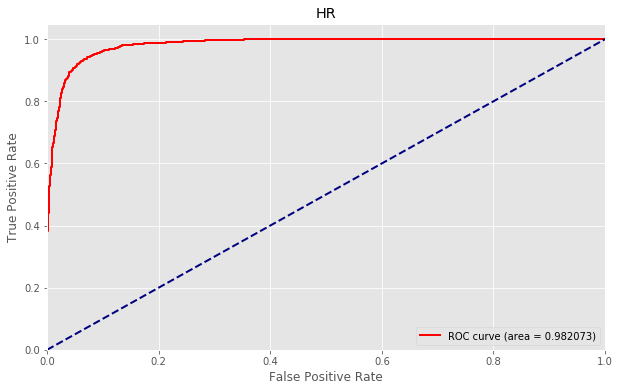

0.9820734444444444

In [17]:
roc_auc_hr = draw_roc(fpr, tpr, name=approach_name)
roc_auc_hr

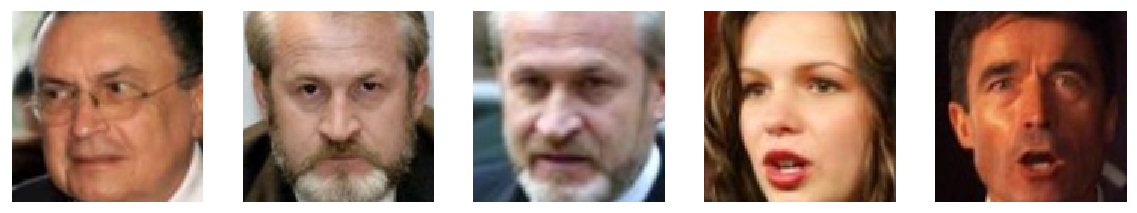

In [18]:
images = show_pil_batch(lwf_loader_hr)

In [19]:
roc_curves[approach_name] = fpr, tpr
roc_auc_scores[approach_name] = roc_auc_hr

## Bicubic interpolation

In [20]:
approach_name = 'Bicubic'

In [21]:
down_up_bicubic = [
    transforms.Resize(32, PIL.Image.NEAREST),
    transforms.Resize(128, PIL.Image.BICUBIC),
]

lwf_dataset_hr = LFWFunneled6000Pairs(LFW_FUNNELED_DIR, LFW_PAIRS_6000, additional_transform=down_up_bicubic)
lwf_loader_hr = DataLoader(
    dataset=lwf_dataset_hr,
    batch_size=16,
    num_workers=4,
    shuffle=False
)

In [22]:
fpr, tpr = calculate_roc(lwf_loader_hr, model)

100%|██████████| 375/375 [00:27<00:00, 15.73it/s]


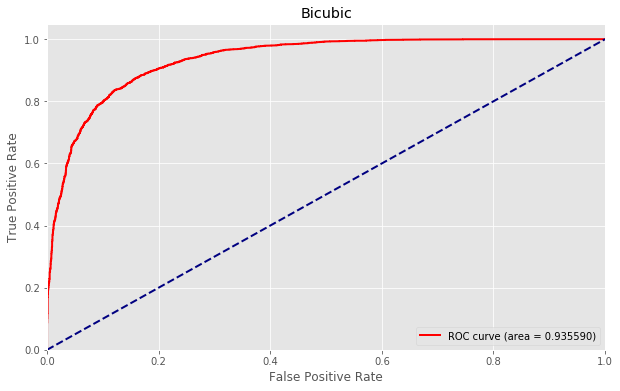

0.9355900555555554

In [23]:
roc_auc_bicubic = draw_roc(fpr, tpr, name=approach_name)
roc_auc_bicubic

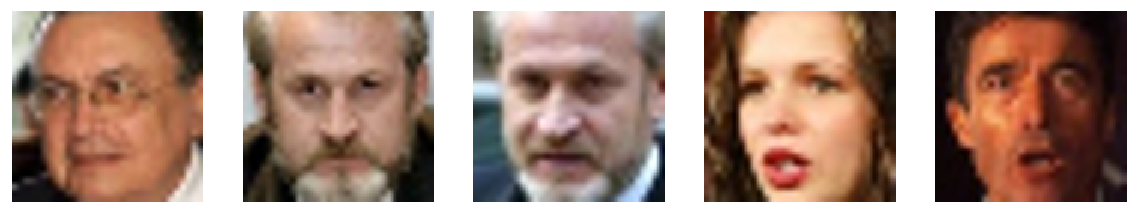

In [24]:
images = show_pil_batch(lwf_loader_hr)

In [25]:
roc_curves[approach_name] = fpr, tpr
roc_auc_scores[approach_name] = roc_auc_bicubic

## SRGAN MSE

In [26]:
def plot_checkpoints_roc_auc(roc_auc_list,
                             step_list,
                             name,
                             lines=roc_auc_scores,
                             main_color='red',
                             horizontal_colors=COLORS_LIST):
    plt.figure(figsize=(10, 6))
    plt.plot(step_list, roc_auc_list, c=main_color)
    plt.ylabel('ROC AUC')
    plt.xlabel('Step')
    plt.title(name)
    plt.xticks(rotation=45)
    
    drawn_list = []
    for num, ((line_name, value), color) in enumerate(
        zip(lines.items(), horizontal_colors)
    ):
        linestyle='-'
        for drawn_value in drawn_list:
            if np.abs(drawn_value - value) < 0.0002:
                linestyle = '--'
                break
            
        plt.axhline(
            y=value,
            color=color, linestyle=linestyle,
            zorder=num,
            label=line_name, lw=2
        )
        drawn_list.append(value)
        
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.ylim([lines['Bicubic'] - 0.003, lines['HR'] + 0.003])
    
    plt.show()

In [27]:
def roc_auc_for_all_checkpoints(name, embeddings_model, upscale_model, weight_directory, lwf_loader_hr,
                                continue_auc_and_files=None):
    def analyse():
        clear_output()
        cur_max_roc_auc_arg = np.argmax(roc_auc_list)
        print('Max ROC AUC is {} on {} step'.format(
            roc_auc_list[cur_max_roc_auc_arg], current_files_list[cur_max_roc_auc_arg]
        ))
        plot_checkpoints_roc_auc(roc_auc_list, current_files_list, name)
        
        return cur_max_roc_auc_arg
    
    files = sorted(os.listdir(weight_directory))
    downscale = [
        transforms.Resize(32, PIL.Image.NEAREST),
    ]
    
    if continue_auc_and_files is not None:
        roc_auc_list, current_files_list = continue_auc_and_files
    else:
        roc_auc_list, current_files_list = [], []
    
    if len(files) > 0:
        last_checkpoint_file_num = os.path.splitext(files[-1])[0]

        for file in files:
            checkpoint_file_num = os.path.splitext(file)[0]
            if checkpoint_file_num in current_files_list:
                continue

            checkpoint_file = os.path.join(weight_directory, file)

            upscale_model.load_state_dict(torch.load(checkpoint_file))

            loading_desc = '{}/{}'.format(checkpoint_file_num, last_checkpoint_file_num)
            roc_auc_list.append(
                calculate_roc_auc(lwf_loader_hr, embeddings_model, upscale_model, loading_desc)
            )
            current_files_list.append(checkpoint_file_num)
            cur_max_roc_auc_arg = analyse() 
    else:
        roc_auc_list, current_files_list, cur_max_roc_auc_arg = [1], [0], 0

    cur_max_roc_auc_arg = analyse()
    
    return roc_auc_list, current_files_list, cur_max_roc_auc_arg

In [28]:
def make_save_path(save_dir, name):
    return os.path.join(save_dir, name.lower().replace(' ', '_'))

def save_roc_auc(name, roc_auc_list, files_list, save_dir=ROC_AUC_DIR):
    save_path = make_save_path(save_dir, name)
    with open(save_path, 'wb') as file:
        pickle.dump((roc_auc_list, files_list), file)
        
def load_roc_auc(name, save_dir=ROC_AUC_DIR):
    load_path = make_save_path(save_dir, name)
    with open(load_path, 'rb') as file:
        roc_auc_list, files_list = pickle.load(file)
    return roc_auc_list, files_list

In [29]:
n_resblocks=16
n_upsample=2
generator = Generator(n_resblocks, n_upsample)
generator = nn.DataParallel(generator).cuda()

In [30]:
downscale = [
    transforms.Resize(32, 0),
]

lwf_dataset_hr = LFWFunneled6000Pairs(LFW_FUNNELED_DIR, LFW_PAIRS_6000, additional_transform=downscale)
lwf_loader_hr = DataLoader(
    dataset=lwf_dataset_hr,
    batch_size=16,
    num_workers=4,
    shuffle=False
)

In [31]:
approach_name = 'MSE Loss'

Max ROC AUC is 0.9595116666666667 on 0000540000 step


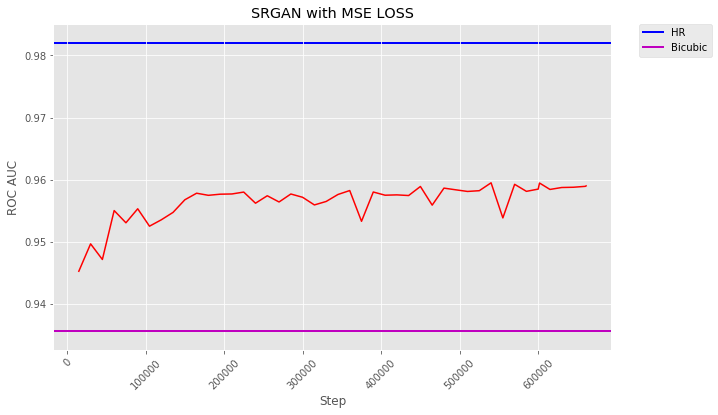

In [32]:
experiment_name = 'SRGAN with MSE LOSS'
roc_auc_list_mse, files_list_mse, max_roc_auc_arg_mse = roc_auc_for_all_checkpoints(
    experiment_name, model, upscale_model=generator,
    weight_directory=SRGAN_MSE_LOSS_WEIGHTS_DIR,
    lwf_loader_hr=lwf_loader_hr,
    continue_auc_and_files=load_roc_auc(approach_name)
)
save_roc_auc(approach_name, roc_auc_list_mse, files_list_mse)

In [33]:
roc_auc_list_mse[max_roc_auc_arg_mse], files_list_mse[max_roc_auc_arg_mse]

(0.9595116666666667, '0000540000')

In [34]:
model_kwargs = {
    'upscale_model': generator,
    'checkpoint_file': os.path.join(SRGAN_MSE_LOSS_WEIGHTS_DIR, files_list_mse[max_roc_auc_arg_mse]) + '.pth'
}

In [35]:
fpr, tpr = calculate_roc(
    lwf_loader_hr, model, **model_kwargs,
)

100%|██████████| 375/375 [00:50<00:00,  8.23it/s]


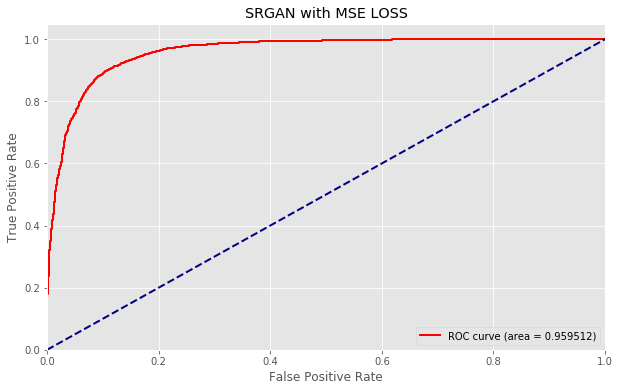

0.9595116666666667

In [36]:
roc_auc = draw_roc(fpr, tpr, experiment_name)
roc_auc

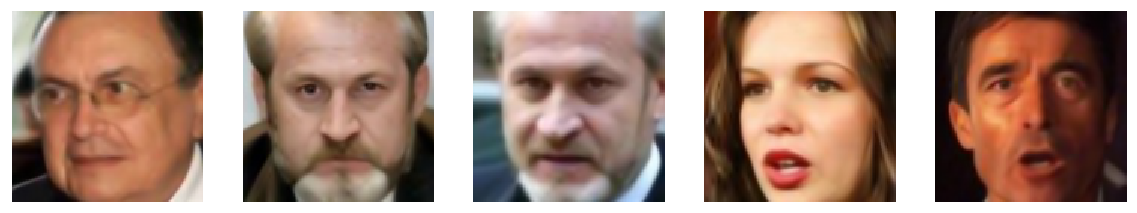

In [37]:
images = show_pil_batch(lwf_loader_hr, **model_kwargs)

In [38]:
roc_auc_scores[approach_name] = roc_auc_list_mse[max_roc_auc_arg_mse]
roc_curves[approach_name] = fpr, tpr

## SRGAN VGG (3.1)

In [39]:
approach_name = 'VGG Loss 3.1'

Max ROC AUC is 0.9634992222222222 on 0000450000 step


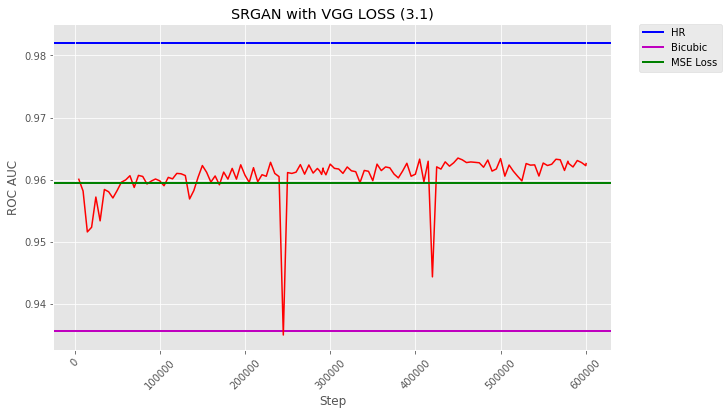

In [40]:
experiment_name = 'SRGAN with VGG LOSS (3.1)'
roc_auc_list_vgg, files_list_vgg, max_roc_auc_arg_vgg = roc_auc_for_all_checkpoints(
    experiment_name, model, upscale_model=generator,
    weight_directory=SRGAN_VGG_LOSS_3_1_GENERATOR_WEIGHTS_DIR,
    lwf_loader_hr=lwf_loader_hr,
    continue_auc_and_files=load_roc_auc(approach_name)
)
save_roc_auc(approach_name, roc_auc_list_vgg, files_list_vgg)

In [41]:
roc_auc_list_vgg[max_roc_auc_arg_vgg], files_list_vgg[max_roc_auc_arg_vgg]

(0.9634992222222222, '0000450000')

In [42]:
model_kwargs = {
    'upscale_model': generator,
    'checkpoint_file': os.path.join(SRGAN_VGG_LOSS_3_1_GENERATOR_WEIGHTS_DIR, files_list_vgg[max_roc_auc_arg_vgg]) + '.pth'
}

In [43]:
fpr, tpr = calculate_roc(
    lwf_loader_hr, model, **model_kwargs,
)

100%|██████████| 375/375 [00:50<00:00,  7.99it/s]


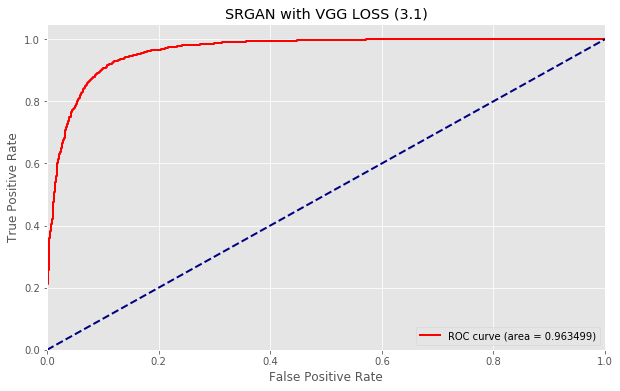

0.9634992222222222

In [44]:
roc_auc = draw_roc(fpr, tpr, experiment_name)
roc_auc

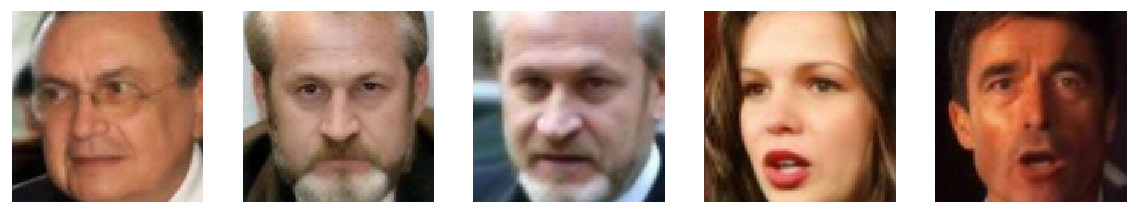

In [45]:
images = show_pil_batch(lwf_loader_hr, **model_kwargs)

In [46]:
roc_auc_scores[approach_name] = roc_auc_list_vgg[max_roc_auc_arg_vgg]
roc_curves[approach_name] = fpr, tpr

## SRGAN VGG (3.1) NO ADVERSARIAL

In [47]:
approach_name = 'VGG Loss 3.1 no adversarial'

Max ROC AUC is 0.9634591111111112 on 0000570000 step


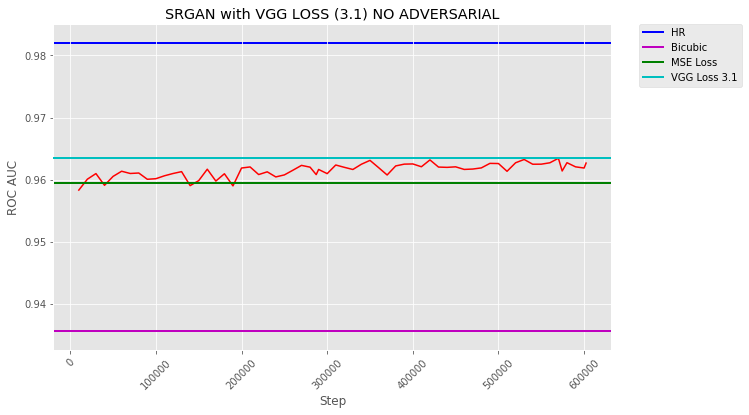

In [48]:
experiment_name = 'SRGAN with VGG LOSS (3.1) NO ADVERSARIAL'
roc_auc_list_vgg_no_adv, files_list_vgg_no_adv, max_roc_auc_arg_vgg_no_adv = roc_auc_for_all_checkpoints(
    experiment_name, model, upscale_model=generator,
    weight_directory=SRGAN_VGG_LOSS_3_1_NO_ADVERSARIAL_WEIGHTS_DIR,
    lwf_loader_hr=lwf_loader_hr,
    continue_auc_and_files=load_roc_auc(approach_name)
)
save_roc_auc(approach_name, roc_auc_list_vgg_no_adv, files_list_vgg_no_adv)

In [49]:
roc_auc_list_vgg_no_adv[max_roc_auc_arg_vgg_no_adv], files_list_vgg_no_adv[max_roc_auc_arg_vgg_no_adv]

(0.9634591111111112, '0000570000')

In [50]:
model_kwargs = {
    'upscale_model': generator,
    'checkpoint_file': os.path.join(SRGAN_VGG_LOSS_3_1_NO_ADVERSARIAL_WEIGHTS_DIR, files_list_vgg_no_adv[max_roc_auc_arg_vgg_no_adv]) + '.pth'
}

In [51]:
fpr, tpr = calculate_roc(
    lwf_loader_hr, model, **model_kwargs
)

100%|██████████| 375/375 [00:51<00:00,  8.10it/s]


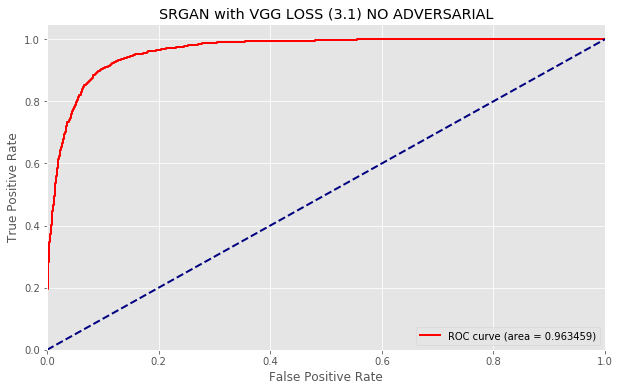

0.9634591111111112

In [52]:
roc_auc = draw_roc(fpr, tpr, experiment_name)
roc_auc

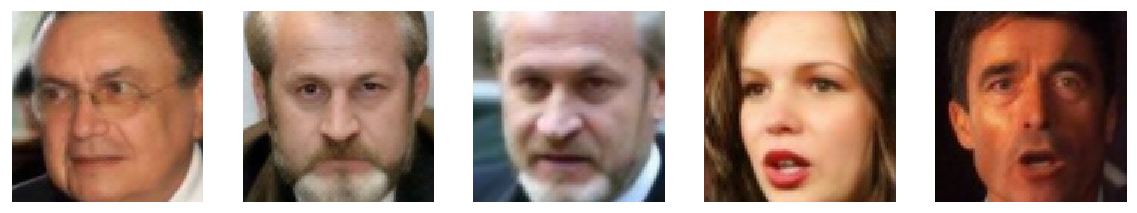

In [53]:
images = show_pil_batch(lwf_loader_hr, **model_kwargs)

In [54]:
roc_auc_scores[approach_name] = roc_auc_list_vgg_no_adv[max_roc_auc_arg_vgg_no_adv]
roc_curves[approach_name] = fpr, tpr

## SRGAN LIGHT CNN 9 (MFM4)

In [55]:
approach_name = 'LIGHT CNN 9 Loss MFM4'

Max ROC AUC is 0.9674166666666666 on 0000570000 step


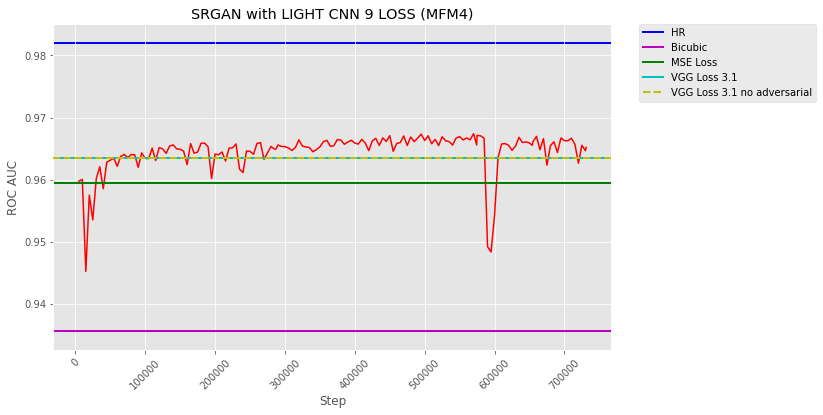

In [56]:
experiment_name = 'SRGAN with LIGHT CNN 9 LOSS (MFM4)'
roc_auc_list_light_cnn, files_list_light_cnn, max_roc_auc_arg_light_cnn = roc_auc_for_all_checkpoints(
    experiment_name, model, upscale_model=generator,
    weight_directory=SRGAN_LIGHT_CNN_9_LOSS_MFM4_GENERATOR_WEIGHTS_DIR,
    lwf_loader_hr=lwf_loader_hr,
    continue_auc_and_files=load_roc_auc(approach_name)
)
save_roc_auc(approach_name, roc_auc_list_light_cnn, files_list_light_cnn)

In [57]:
roc_auc_list_light_cnn[max_roc_auc_arg_light_cnn], files_list_light_cnn[max_roc_auc_arg_light_cnn]

(0.9674166666666666, '0000570000')

In [58]:
model_kwargs = {
    'upscale_model': generator,
    'checkpoint_file': os.path.join(SRGAN_LIGHT_CNN_9_LOSS_MFM4_GENERATOR_WEIGHTS_DIR, files_list_light_cnn[max_roc_auc_arg_light_cnn]) + '.pth'
}

In [59]:
fpr, tpr = calculate_roc(
    lwf_loader_hr, model, **model_kwargs,
)

100%|██████████| 375/375 [00:51<00:00,  7.89it/s]


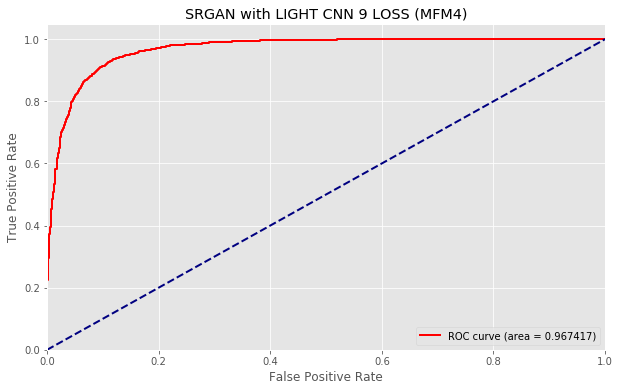

0.9674166666666666

In [60]:
roc_auc = draw_roc(fpr, tpr, experiment_name)
roc_auc

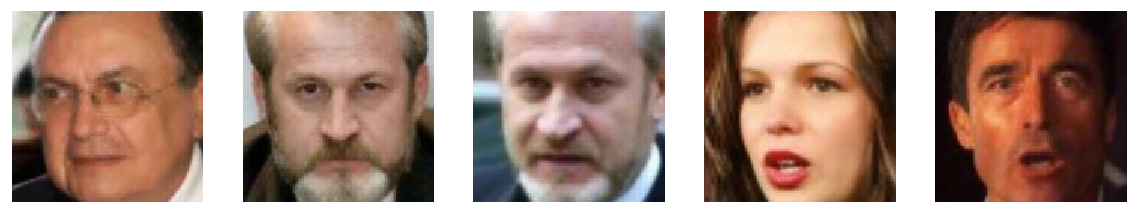

In [61]:
images = show_pil_batch(lwf_loader_hr, **model_kwargs)

In [62]:
roc_auc_scores[approach_name] = roc_auc_list_light_cnn[max_roc_auc_arg_light_cnn]
roc_curves[approach_name] = fpr, tpr

## SRGAN LIGHT CNN 9 (MFM4) NO ADVERSARIAL

In [63]:
approach_name = 'LIGHT CNN 9 Loss MFM4 no adversarial'

Max ROC AUC is 0.9683207777777777 on 0000760000 step


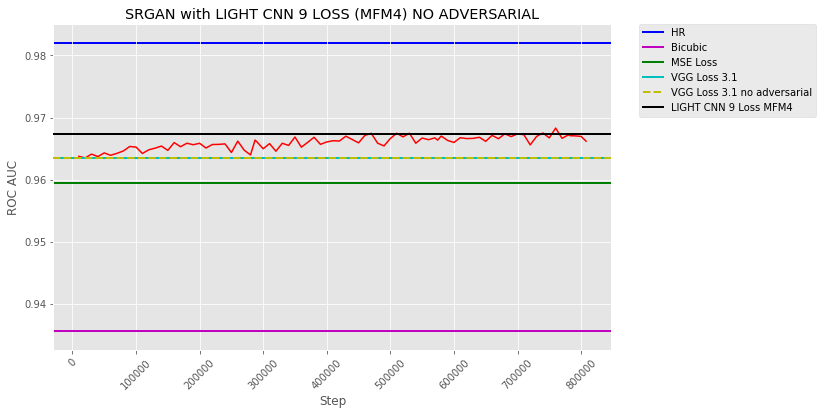

In [64]:
experiment_name = 'SRGAN with LIGHT CNN 9 LOSS (MFM4) NO ADVERSARIAL'
roc_auc_list_light_cnn_no_adv, files_list_light_cnn_no_adv, max_roc_auc_arg_light_cnn_no_adv = roc_auc_for_all_checkpoints(
    experiment_name, model, upscale_model=generator,
    weight_directory=SRGAN_LIGHT_CNN_9_LOSS_MFM4_NO_ADVERSARIAL_WEIGHTS_DIR,
    lwf_loader_hr=lwf_loader_hr,
    continue_auc_and_files=load_roc_auc(approach_name)
)
save_roc_auc(approach_name, roc_auc_list_light_cnn_no_adv, files_list_light_cnn_no_adv)

In [65]:
roc_auc_list_light_cnn_no_adv[max_roc_auc_arg_light_cnn_no_adv], files_list_light_cnn_no_adv[max_roc_auc_arg_light_cnn_no_adv]

(0.9683207777777777, '0000760000')

In [66]:
model_kwargs = {
    'upscale_model': generator,
    'checkpoint_file': os.path.join(SRGAN_LIGHT_CNN_9_LOSS_MFM4_NO_ADVERSARIAL_WEIGHTS_DIR, files_list_light_cnn_no_adv[max_roc_auc_arg_light_cnn_no_adv]) + '.pth'
}

In [67]:
fpr, tpr = calculate_roc(
    lwf_loader_hr, model, **model_kwargs,
)

100%|██████████| 375/375 [00:50<00:00,  7.85it/s]


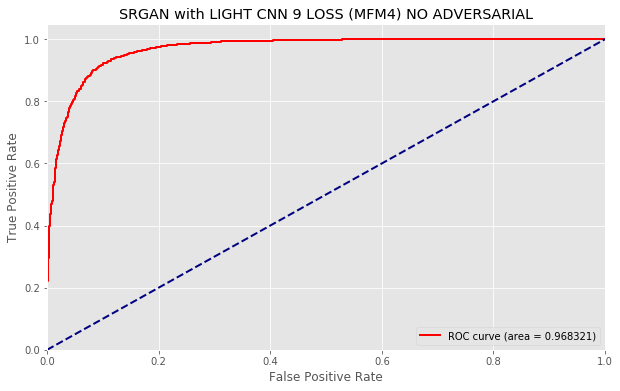

0.9683207777777777

In [68]:
roc_auc = draw_roc(fpr, tpr, experiment_name)
roc_auc

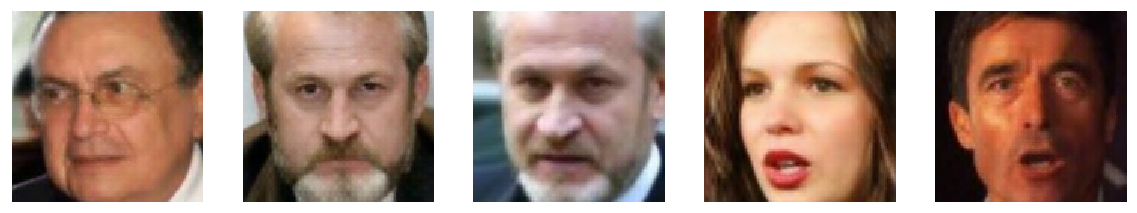

In [69]:
images = show_pil_batch(lwf_loader_hr, **model_kwargs)

In [70]:
roc_auc_scores[approach_name] = roc_auc_list_light_cnn_no_adv[max_roc_auc_arg_light_cnn_no_adv]
roc_curves[approach_name] = fpr, tpr

## SRGAN LIGHT CNN 9 (FC) NO ADVERSARIAL

In [71]:
approach_name = 'LIGHT CNN 9 Loss FC no adversarial'

Max ROC AUC is 0.9659422222222223 on 0000680000 step


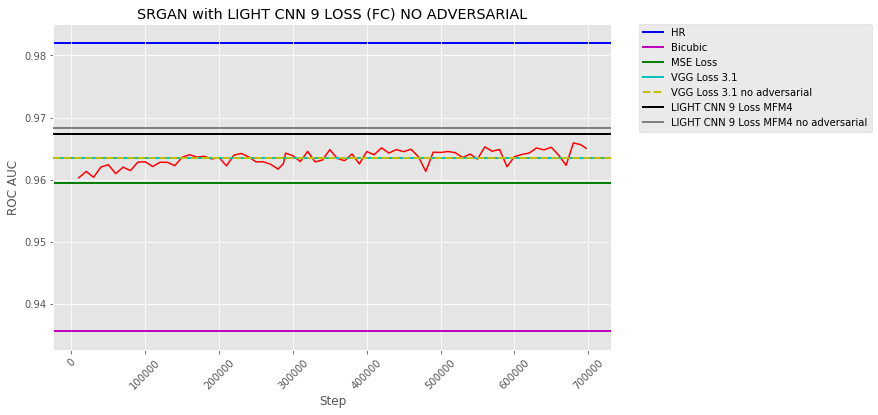

In [72]:
experiment_name = 'SRGAN with LIGHT CNN 9 LOSS (FC) NO ADVERSARIAL'
roc_auc_list_light_cnn_fc_no_adv, files_list_light_cnn_fc_no_adv, max_roc_auc_arg_light_cnn_fc_no_adv = roc_auc_for_all_checkpoints(
    experiment_name, model, upscale_model=generator,
    weight_directory=SRGAN_LIGHT_CNN_9_LOSS_FC_NO_ADVERSARIAL_WEIGHTS_DIR,
    lwf_loader_hr=lwf_loader_hr,
    continue_auc_and_files=load_roc_auc(approach_name)
)
save_roc_auc(approach_name, roc_auc_list_light_cnn_fc_no_adv, files_list_light_cnn_fc_no_adv)

In [73]:
roc_auc_list_light_cnn_fc_no_adv[max_roc_auc_arg_light_cnn_fc_no_adv], files_list_light_cnn_fc_no_adv[max_roc_auc_arg_light_cnn_fc_no_adv]

(0.9659422222222223, '0000680000')

In [74]:
model_kwargs = {
    'upscale_model': generator,
    'checkpoint_file': os.path.join(SRGAN_LIGHT_CNN_9_LOSS_FC_NO_ADVERSARIAL_WEIGHTS_DIR, files_list_light_cnn_fc_no_adv[max_roc_auc_arg_light_cnn_fc_no_adv]) + '.pth'
}

In [75]:
fpr, tpr = calculate_roc(
    lwf_loader_hr, model, **model_kwargs,
)

100%|██████████| 375/375 [00:52<00:00,  8.15it/s]


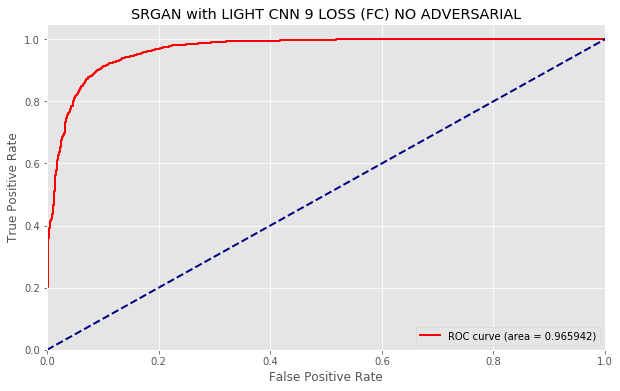

0.9659422222222223

In [76]:
roc_auc = draw_roc(fpr, tpr, experiment_name)
roc_auc

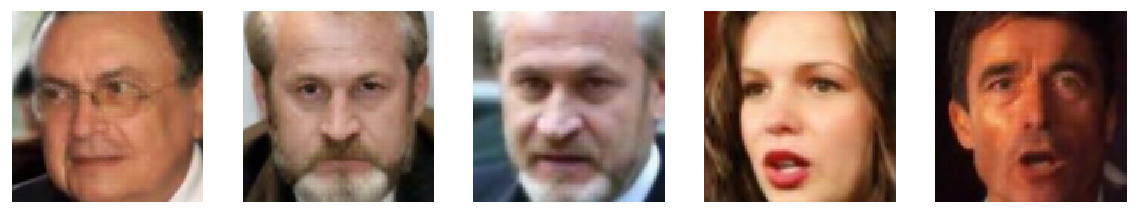

In [77]:
images = show_pil_batch(lwf_loader_hr, **model_kwargs)

In [78]:
roc_auc_scores[approach_name] = roc_auc_list_light_cnn_fc_no_adv[max_roc_auc_arg_light_cnn_fc_no_adv]
roc_curves[approach_name] = fpr, tpr

## SRGAN LIGHT CNN 9 (MFM4) NO ADVERSARIAL NO IMAGE

In [79]:
approach_name = 'LIGHT CNN 9 Loss MFM4 no adversarial no image'

Max ROC AUC is 0.964212888888889 on 0000510000 step


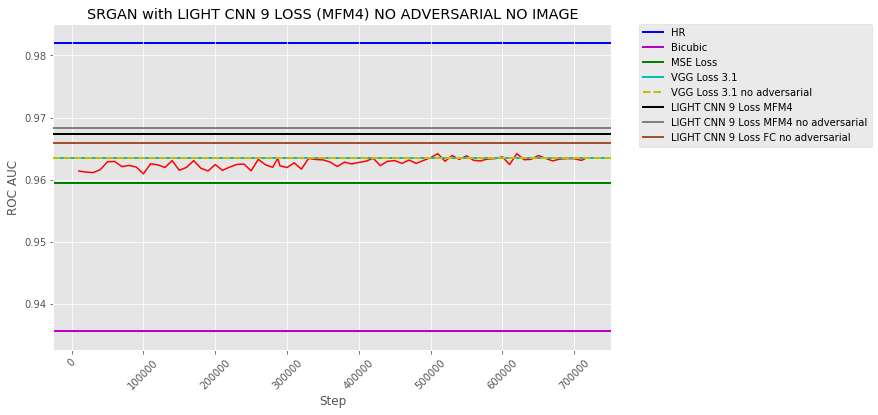

In [80]:
experiment_name = 'SRGAN with LIGHT CNN 9 LOSS (MFM4) NO ADVERSARIAL NO IMAGE'
roc_auc_list_light_cnn_no_adv_no_image, files_list_light_cnn_no_adv_no_image, max_roc_auc_arg_light_cnn_no_adv_no_image = roc_auc_for_all_checkpoints(
    experiment_name, model, upscale_model=generator,
    weight_directory=SRGAN_LIGHT_CNN_9_LOSS_MFM4_NO_ADVERSARIAL_NO_IMAGE_WEIGHTS_DIR,
    lwf_loader_hr=lwf_loader_hr,
    continue_auc_and_files=load_roc_auc(approach_name)
)
save_roc_auc(approach_name, roc_auc_list_light_cnn_no_adv_no_image, files_list_light_cnn_no_adv_no_image)

In [81]:
roc_auc_list_light_cnn_no_adv_no_image[max_roc_auc_arg_light_cnn_no_adv_no_image], files_list_light_cnn_no_adv_no_image[max_roc_auc_arg_light_cnn_no_adv_no_image]

(0.964212888888889, '0000510000')

In [82]:
model_kwargs = {
    'upscale_model': generator,
    'checkpoint_file': os.path.join(SRGAN_LIGHT_CNN_9_LOSS_MFM4_NO_ADVERSARIAL_NO_IMAGE_WEIGHTS_DIR, files_list_light_cnn_no_adv_no_image[max_roc_auc_arg_light_cnn_no_adv_no_image]) + '.pth'
}

In [83]:
fpr, tpr = calculate_roc(
    lwf_loader_hr, model, **model_kwargs,
)

100%|██████████| 375/375 [00:50<00:00,  7.70it/s]


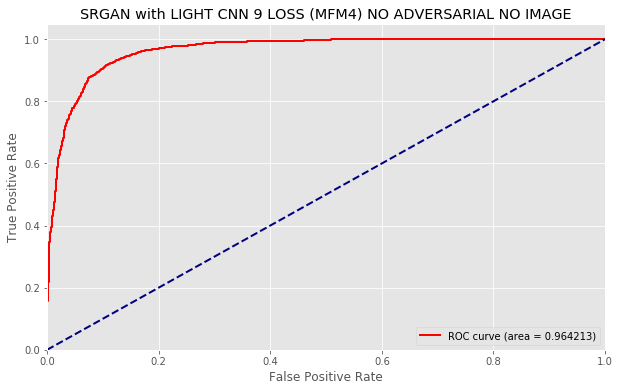

0.964212888888889

In [84]:
roc_auc = draw_roc(fpr, tpr, experiment_name)
roc_auc

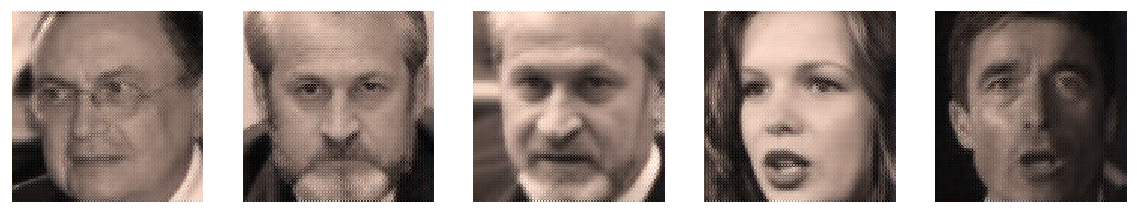

In [85]:
images = show_pil_batch(lwf_loader_hr, **model_kwargs)

In [86]:
roc_auc_scores[approach_name] = roc_auc_list_light_cnn_no_adv_no_image[max_roc_auc_arg_light_cnn_no_adv_no_image]
roc_curves[approach_name] = fpr, tpr

# Overall ROC

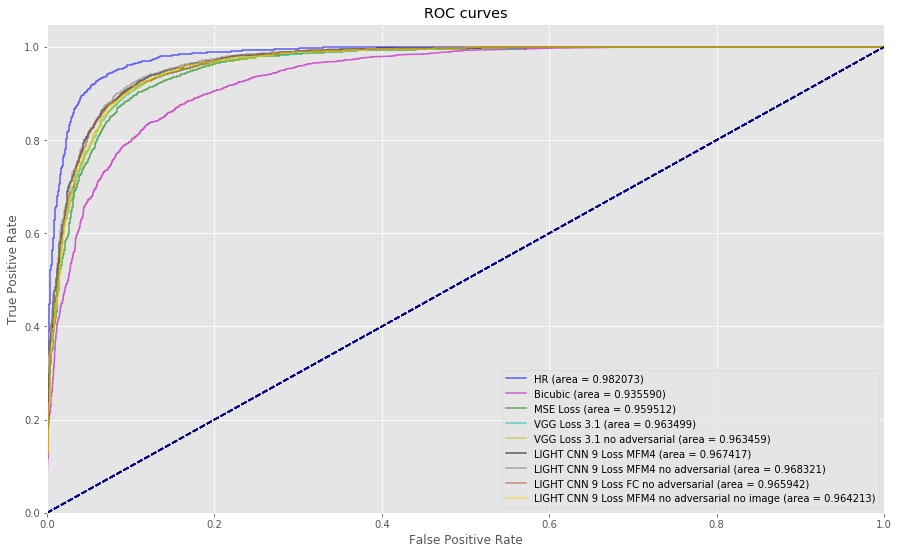

In [87]:
draw_rocs(roc_curves)

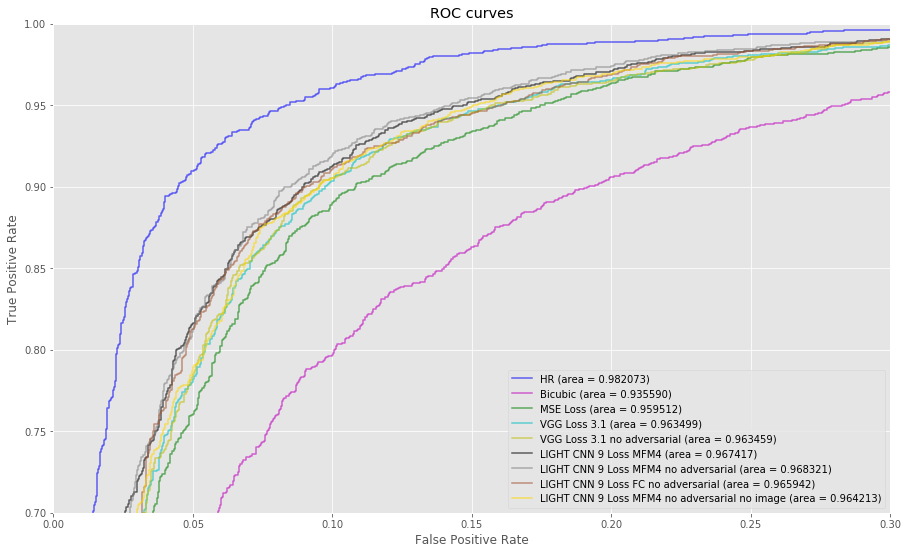

In [88]:
draw_rocs(roc_curves, crop=True)